# Global Modelling
This workbook is focused around the task:
- Modelling Oslo's Public Transit Network as a Layered Graph
- Applying Dinic's algorithm for finding max-flow
- Categorizing Sentrality and general inspection of data

## Step 0 - Imports & Data Loading

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import folium

#Oslo = county/Fylke 03
stops_oslo = pd.read_csv("../../Extraction/out/nodes_GTFS_OSLO.csv")
edges_oslo = pd.read_csv("../../Extraction/out/edges_GTFS_OSLO.csv")

#Greater Area: Oslo (03), Akershus(32), Buskerud (33), Østfold (31)
stops_oslo_expanded = pd.read_csv("../../Extraction/out/nodes_GTFS_ALL_FYLKER.csv")
egdes_oslo_expanded = pd.read_csv("../../Extraction/out/edges_GTFS_ALL_FYLKER.csv")

stops = pd.read_csv("../../Extraction/out/nodes_GTFS_ALL_FYLKER.csv")
edges = pd.read_csv("../../Extraction/out/edges_GTFS_ALL_FYLKER.csv")

#display(stops_oslo.head()) 
#display(edges_oslo.head())
#display(stops_oslo_expanded.head()) 
#display(egdes_oslo_expanded.head())
print(f"Edges shape: {edges.shape} | Nodes/Stops shape: {stops.shape}")
print("Unique modes in edges:", edges["mode"].unique())
print("\nCounts per mode:")
print(edges["mode"].value_counts())


Edges shape: (42538, 7) | Nodes/Stops shape: (15838, 7)
Unique modes in edges: ['unknown' 'bus' 'coach service' 'rail' 'metro' 'tram']

Counts per mode:
mode
bus              40016
rail              1156
coach service      605
metro              404
tram               300
unknown             57
Name: count, dtype: int64


## Step 1: Modelling Nodes and Edges
Before modifying the dataset further, a simple visualization was made to verify the usability of the data

In [2]:
import numpy as np
import networkx as nx

# 1) Inspect & fix the stops / edges DataFrames up front
print("Raw stops columns:", stops.columns.tolist())
print("Raw edges columns:", edges.columns.tolist())

# Ensure we have an 'id' column for stops
if "id" not in stops.columns:
    if "stopPlaceId" in stops.columns:
        stops["id"] = stops["stopPlaceId"]
        print("stops: 'id' column missing, using 'stopPlaceId' as id.")
    else:
        raise ValueError("stops has neither 'id' nor 'stopPlaceId' column.")

# Drop stops with missing coordinates
n_stops_raw = len(stops)
stops_clean = stops.dropna(subset=["lat", "lon"]).copy()
n_stops_clean = len(stops_clean)
lost_stops_no_coord = n_stops_raw - n_stops_clean

# Set of node ids that actually have coordinates
valid_node_ids = set(stops_clean["id"])

# Ensure 'from'/'to' exist in edges (rename if needed)
if "from" not in edges.columns:
    # try common alternative names if this ever happens
    for cand in ["from_stop_id", "from_id"]:
        if cand in edges.columns:
            edges = edges.rename(columns={cand: "from"})
            print(f"edges: renamed '{cand}' -> 'from'")
            break
if "to" not in edges.columns:
    for cand in ["to_stop_id", "to_id"]:
        if cand in edges.columns:
            edges = edges.rename(columns={cand: "to"})
            print(f"edges: renamed '{cand}' -> 'to'")
            break

# Drop edges where 'from' or 'to' is missing or not in valid_node_ids
n_edges_raw = len(edges)
edges_clean = edges.dropna(subset=["from", "to"]).copy()
mask_valid_endpoints = (
    edges_clean["from"].isin(valid_node_ids) &
    edges_clean["to"].isin(valid_node_ids)
)
edges_clean = edges_clean[mask_valid_endpoints].copy()
n_edges_clean = len(edges_clean)
lost_edges_bad_nodes = n_edges_raw - n_edges_clean

print(f"Total stops (raw): {n_stops_raw}")
print(f"  Usable stops with coordinates: {n_stops_clean}")
print(f"  Dropped stops (no lat/lon): {lost_stops_no_coord}")
print(f"Total edges (raw): {n_edges_raw}")
print(f"  Usable edges (both endpoints have coords): {n_edges_clean}")
print(f"  Dropped edges (missing/invalid endpoints): {lost_edges_bad_nodes}")

# 2) Build the graph from the cleaned DataFrames
G = nx.DiGraph()

# Add nodes
for _, row in stops_clean.iterrows():
    node_id = row["id"]
    G.add_node(
        node_id,
        stopPlaceId=row.get("stopPlaceId"),
        name=row.get("name"),
        lat=row.get("lat"),
        lon=row.get("lon"),
        modes=row.get("modes"),
        stopType=row.get("stopType"),
    )

# Add edges
for _, row in edges_clean.iterrows():
    u = row["from"]
    v = row["to"]

    travel_time = row.get("travelTimeSec", None)
    capacity = 1  # temp, to be defined properly later

    G.add_edge(
        u,
        v,
        lineId=row.get("lineId"),
        lineCode=row.get("lineCode"),
        mode=row.get("mode"),
        authority=row.get("authority"),
        travelTimeSec=travel_time,
        capacity=capacity,
    )

# 3) Final graph stats
print("Graph nodes:", G.number_of_nodes())
print("Graph edges:", G.number_of_edges())

# 4) Build pos dict once, now guaranteed to exist for all nodes in G
pos = {
    n: (data["lon"], data["lat"])
    for n, data in G.nodes(data=True)
    if data.get("lon") is not None and data.get("lat") is not None
}
print(f"Positions built for {len(pos)} nodes.")


Raw stops columns: ['id', 'stopPlaceId', 'name', 'lat', 'lon', 'modes', 'stopType']
Raw edges columns: ['from', 'to', 'lineId', 'lineCode', 'mode', 'authority', 'travelTimeSec']
Total stops (raw): 15838
  Usable stops with coordinates: 15838
  Dropped stops (no lat/lon): 0
Total edges (raw): 42538
  Usable edges (both endpoints have coords): 42538
  Dropped edges (missing/invalid endpoints): 0
Graph nodes: 15838
Graph edges: 21385
Positions built for 15838 nodes.


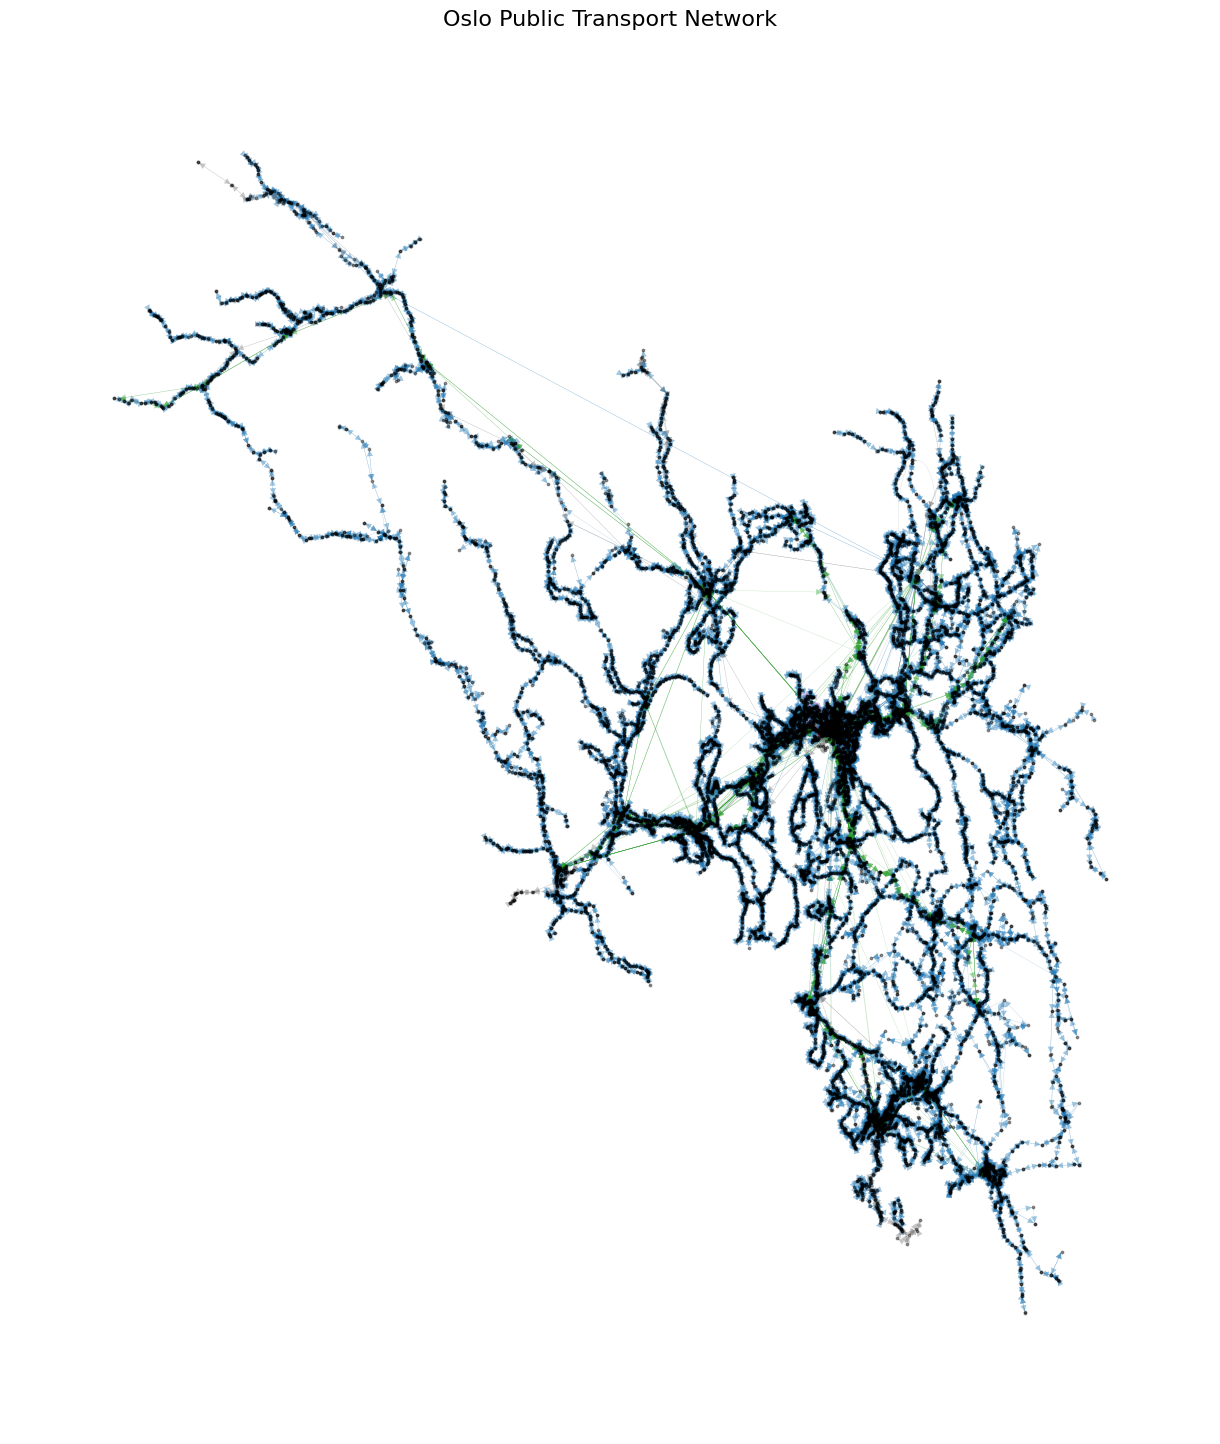

In [4]:

# Defining Mode Colors to differentiate between modes in Graph
mode_colors = {
    "bus":        "#1f77b4",   # deep blue
    "tram":       "#d62728",   # strong red
    "metro":      "#9467bd",   # purple 
    "rail":       "#2ca02c",   # green 
    "coach":      "#ff7f0e",   # orange
    "water":      "#17becf",   # teal
    "unknown":    "#7f7f7f",   # neutral gray
}

edge_colors = [
    mode_colors.get(data["mode"], "gray") 
    for _, _, data in G.edges(data=True)
]

plt.figure(figsize=(12, 14))
nx.draw(
    G,
    pos,
    node_size=3,
    node_color="black",
    edge_color=edge_colors,
    width=0.2,
    alpha=0.4,
    with_labels=False
)

plt.title("Oslo Public Transport Network", fontsize=16)
plt.axis("off")
plt.savefig("images/RawNetworkColorCoded.png", dpi=300, bbox_inches="tight")
plt.show()


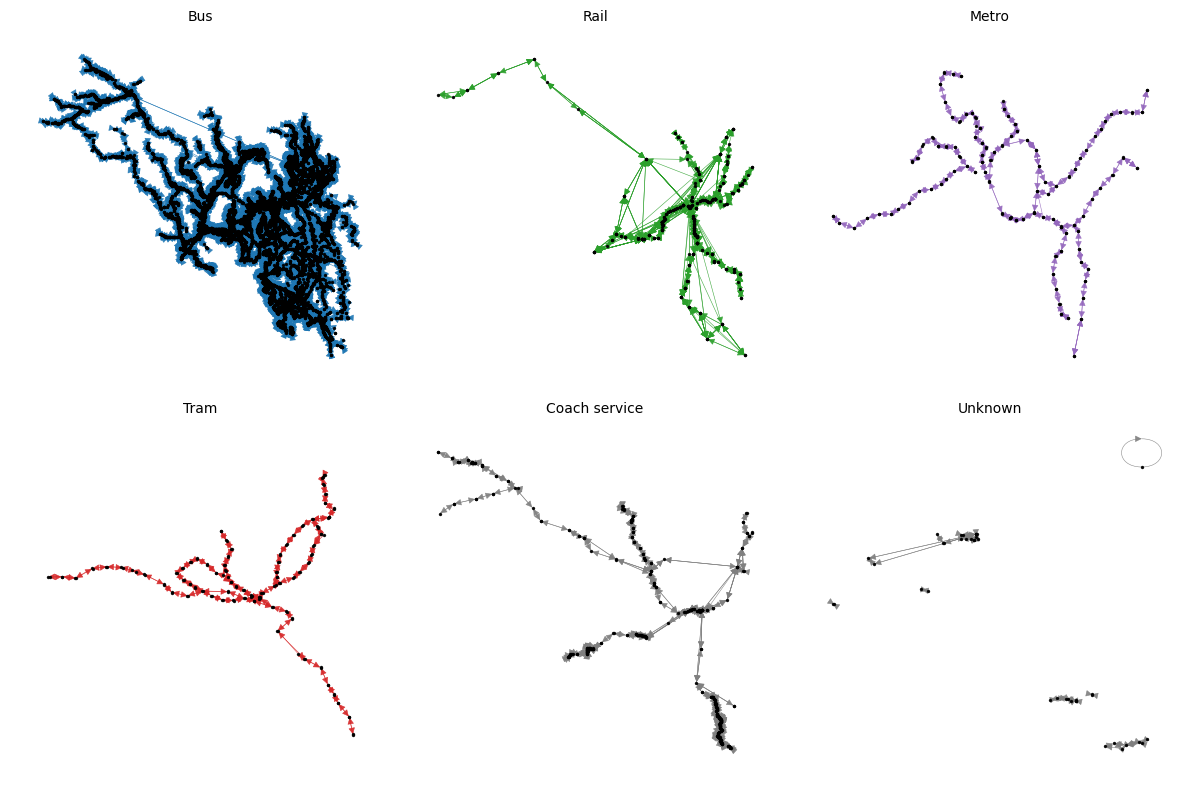

In [5]:
modes = ["bus", "rail", "metro", "tram", "coach service", "unknown"]

fig, axs = plt.subplots(2, 3, figsize=(12, 8))  # nice and compact

for ax, mode in zip(axs.flat, modes):
    ax.set_title(mode.capitalize(), fontsize=10)

    # edges for this mode
    edges_of_mode = [
        (u, v) for u, v, data in G.edges(data=True)
        if data.get("mode") == mode
    ]

    # nodes participating in those edges
    nodes_of_mode = set()
    for u, v in edges_of_mode:
        nodes_of_mode.add(u)
        nodes_of_mode.add(v)

    edge_colors = [mode_colors.get(mode, "gray")] * len(edges_of_mode)


    
    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=False,
        nodelist=list(nodes_of_mode),
        edgelist=edges_of_mode,
        node_size=2,        # tiny nodes
        node_color="black",
        edge_color=edge_colors,
        width=0.4,          # thin edges
        alpha=0.9
    )

    ax.axis("off")

plt.tight_layout()
plt.show()


In [6]:
modes = ["bus", "rail", "metro", "tram", "coach service", "unknown"]

# 1. ONE HTML FOR EACH MODE
for mode in modes:
    print(f"Generating map for mode: {mode}")

    m = folium.Map(
        location=[59.9139, 10.7522],
        zoom_start=12,
        tiles="cartodbpositron"
    )

    # edges
    for u, v, data in G.edges(data=True):
        if data.get("mode") != mode:
            continue

        lat1, lon1 = G.nodes[u]["lat"], G.nodes[u]["lon"]
        lat2, lon2 = G.nodes[v]["lat"], G.nodes[v]["lon"]

        folium.PolyLine(
            locations=[(lat1, lon1), (lat2, lon2)],
            color=mode_colors.get(mode, "gray"),
            weight=2,
            opacity=0.8
        ).add_to(m)

    # nodes
    for n in G.nodes:
        # only nodes belonging to this mode
        if mode not in G.nodes[n]["modes"]:
            continue

        folium.CircleMarker(
            location=(G.nodes[n]["lat"], G.nodes[n]["lon"]),
            radius=2,
            color="black",
            fill=True,
            fill_opacity=1
        ).add_to(m)

    # save output
    filename = f"oslo_{mode.replace(' ', '_')}.html"
    m.save(filename)

print("Individual mode maps saved.")


# 2. MASTER HTML WITH ALL MODES
print("Generating combined multimodal map...")

m_all = folium.Map(
    location=[59.9139, 10.7522],
    zoom_start=12,
    tiles="cartodbpositron"
)

# edges
for u, v, data in G.edges(data=True):
    lat1, lon1 = G.nodes[u]["lat"], G.nodes[u]["lon"]
    lat2, lon2 = G.nodes[v]["lat"], G.nodes[v]["lon"]
    mode = data.get("mode")

    folium.PolyLine(
        locations=[(lat1, lon1), (lat2, lon2)],
        color=mode_colors.get(mode, "gray"),
        weight=1.5,
        opacity=0.7,
    ).add_to(m_all)

# nodes
for n in G.nodes:
    folium.CircleMarker(
        location=(G.nodes[n]["lat"], G.nodes[n]["lon"]),
        radius=1.5,
        color="black",
        fill=True,
        fill_opacity=1
    ).add_to(m_all)

m_all.save("oslo_network_all_modes.html")

print("Combined map saved.")


Generating map for mode: bus
Generating map for mode: rail
Generating map for mode: metro
Generating map for mode: tram
Generating map for mode: coach service
Generating map for mode: unknown
Individual mode maps saved.
Generating combined multimodal map...
Combined map saved.
